### - 1 in every 8 people in the world live with a mental disorder
### - The majority of suicides worldwide are related to mental health disorders; depression, substance use, and psychosis
### - The World Health Organization (WHO) reports that suicide is one of the leading causes of death among individuals aged 15-19

## The Idea: 

## Show ingishts about what people suffering from those disorders are talking about through topic modelling

## Build a mental health recommendation system offering personalized advice derived from shared community experiences of like-minded people by leveraging text analytics, NLP and LLM.

## Recommender System overview

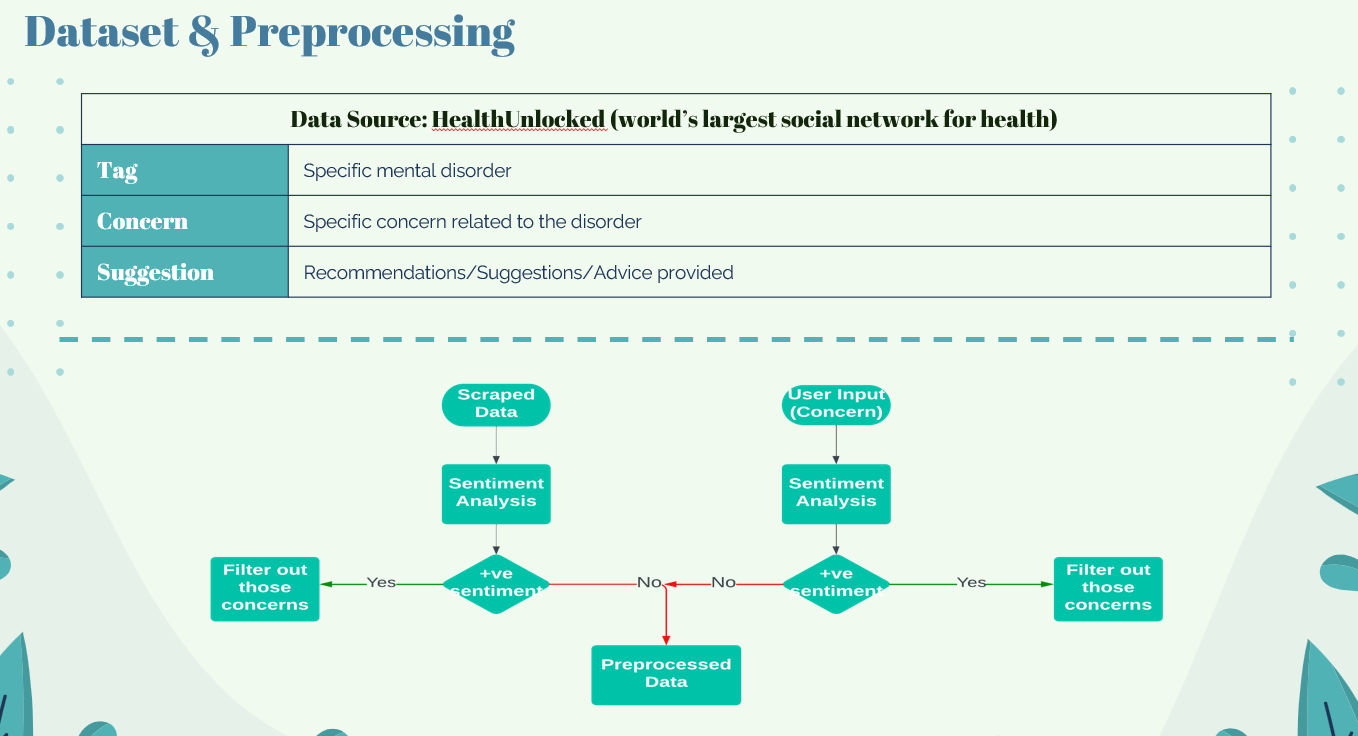

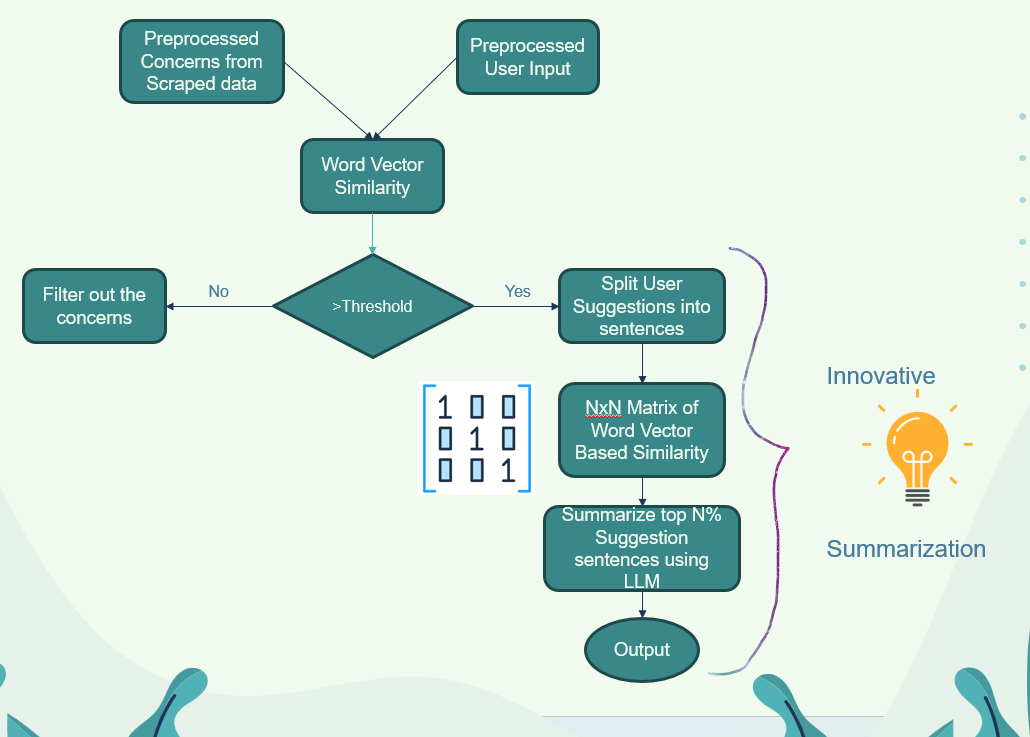

In [1]:
#Importing necessary libraries
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from transformers import BertTokenizer, BertModel
from transformers import pipeline
import io

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### We are scraping data from a medical forum for 5 mental disorders people are talking about. ####

#### We have the tag(disorder), title of the concern, the user concerns, and the suggestions offered by people for that concern ####

# Scraper Code

- We have used a scrapy scraper along with BeautifulSoup for this exercise as we figured it was a fast way to scrape the data one-time as it was a lot of data and pages to scrape at one go. 

- We will be attaching the scrapy project folder along to run the scraper in case needed

- We can run it by running "scrapy crawl mental_health -o beer_reviews.csv" in the same folder in which we see items and settings and middlewares files

- However, just attaching the scrapy spider code here for reference 

In [2]:


'''
import scrapy
from mental_health.items import MentalHealthItem
from scrapy.selector import Selector
import requests
import re
import urllib.request
from urllib.parse import urlparse
from w3lib.html import  remove_tags
import unicodedata
import datetime
from urllib.parse import urljoin
from mental_health import settings
import logging
from w3lib.http import basic_auth_header
from scrapy import signals
from pydispatch import dispatcher
from scrapy.http import FormRequest
from lxml.html import fromstring
from bs4 import BeautifulSoup


class scraper(scrapy.Spider):
    name="mental_health"
    allowed_domains = ["healthunlocked.com"]
    
    PROJECT_ROOT=settings.PROJECT_ROOT

    def start_requests(self):
    
        urls=[]
        pages= range(1,100)
        for i in pages:
            urls.append('https://healthunlocked.com/tag/bipolar%20disorder?page={}&community=all'.format(i))
            urls.append('https://healthunlocked.com/tag/obsessive%20compulsive%20disorder%20ocd?page={}&community=all'.format(i))
            urls.append('https://healthunlocked.com/tag/anxiety?page={}&community=all'.format(i))
            urls.append('https://healthunlocked.com/tag/clinical%20depression?page={}&community=all'.format(i))
            urls.append('https://healthunlocked.com/tag/post%20traumatic%20stress%20disorder%20ptsd?page={}&community=all'.format(i))
        
        for i in urls:
            yield scrapy.Request(i, callback=self.links)
    
    def links(self,response):
        lin=[]
        hxs = Selector(response)
        self.tag=hxs.xpath('//a[@class="active"]/@href').extract()[0].replace('/tag/','')
        hrefs= hxs.xpath('//div[@class="results-posts"]//a//h3//parent::*/@href').extract()
        for i in hrefs:
            yield scrapy.Request(urljoin('https://healthunlocked.com',i), callback=self.parse)


    def parse(self, response):
        hxs = Selector(response)
        
        header= hxs.xpath('//h1[@id="post-heading"]//text()').extract()[0]
        prob=hxs.xpath('//div[@class="post-body"]//text()').extract()
        for quote in hxs.xpath('//div[@class="sc-d94c948d-0 grqulI"]'):
            bodies = BeautifulSoup(' '.join(quote.xpath('./p/text()').extract()))
            bodies = bodies.get_text().strip()
            
            item= MentalHealthItem()
            item["title"]=header
            item['tag']=self.tag
            item['Concern']=prob
            item["Suggestion"]=bodies
            
            yield item
''' 

'\nimport scrapy\nfrom mental_health.items import MentalHealthItem\nfrom scrapy.selector import Selector\nimport requests\nimport re\nimport urllib.request\nfrom urllib.parse import urlparse\nfrom w3lib.html import  remove_tags\nimport unicodedata\nimport datetime\nfrom urllib.parse import urljoin\nfrom mental_health import settings\nimport logging\nfrom w3lib.http import basic_auth_header\nfrom scrapy import signals\nfrom pydispatch import dispatcher\nfrom scrapy.http import FormRequest\nfrom lxml.html import fromstring\nfrom bs4 import BeautifulSoup\n\n\nclass scraper(scrapy.Spider):\n    name="mental_health"\n    allowed_domains = ["healthunlocked.com"]\n    \n    PROJECT_ROOT=settings.PROJECT_ROOT\n\n    def start_requests(self):\n    \n        urls=[]\n        pages= range(1,100)\n        for i in pages:\n            urls.append(\'https://healthunlocked.com/tag/bipolar%20disorder?page={}&community=all\'.format(i))\n            urls.append(\'https://healthunlocked.com/tag/obsessive

# Insights about disorders based on Topic Modelling

In [4]:
!pip install bertopic

  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 37.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for cython<3,>=0.27 from https://files.pythonhosted.org/packages/f8/26/ca0f1bb049b83c25cafa39f3fa5287c826a6ab36e665c906209e07f4deac/Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.

In [9]:
from bertopic import BERTopic

df=pd.read_csv('../input/scraped-data/suggestions.csv')
df.drop_duplicates(subset='Concern', keep='first', inplace=True)
df[:5]

,title,tag,Concern,Suggestion
0,Medication experiences,obsessive-compulsive-disorder-ocd,"Hello. I am a 51 y/o man, suffering from Bipo...",drugs.com says their are no interaction issues.
2,Depression/OCD crisis,obsessive-compulsive-disorder-ocd,"Trigger warning…,Having a breakdown of crisis....",I feel that. I was for real having a breakdown...
8,Finally diagnosed + Fluoxetine help,obsessive-compulsive-disorder-ocd,Today I finally went to a psychiatrist and got...,They will make you feel worse before they star...
11,very depressed,obsessive-compulsive-disorder-ocd,I don’t even know if I have the ability to typ...,I am so sorry for your suffering. I am glad y...
29,the keyword,obsessive-compulsive-disorder-ocd,"Is this PTSD? ,Last week a special word lead m...","Hi kainasar, I am sorry your distressing memor..."


In [10]:
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_words = [word for word in filtered_words if word.isalnum()]
    return " ".join(filtered_words)

df['Concern'] = df['Concern'].astype(str).apply(remove_stopwords)

In [11]:
df_ocd= df[df['tag']=='obsessive-compulsive-disorder-ocd'].reset_index(drop=True)
df_ptsd= df[df['tag']=='post-traumatic-stress-disorder-ptsd'].reset_index(drop=True)
df_anxiety= df[df['tag']=='anxiety'].reset_index(drop=True)
df_depression= df[df['tag']=='clinical-depression'].reset_index(drop=True)
df_bipolar= df[df['tag']=='bipolar-disorder'].reset_index(drop=True)

In [12]:
docs = df_ocd['Concern'].to_list()
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(docs)
model.get_topic_freq().head(11)
model.visualize_barchart()

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

2023-11-11 14:19:58,610 - BERTopic - Transformed documents to Embeddings
2023-11-11 14:20:12,574 - BERTopic - Reduced dimensionality
2023-11-11 14:20:12,630 - BERTopic - Clustered reduced embeddings


In [13]:
docs = df_ptsd['Concern'].to_list()
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(docs)
model.get_topic_freq().head(11)
model.visualize_barchart()

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

2023-11-11 14:21:14,933 - BERTopic - Transformed documents to Embeddings
2023-11-11 14:21:23,752 - BERTopic - Reduced dimensionality
2023-11-11 14:21:23,831 - BERTopic - Clustered reduced embeddings


In [14]:
docs = df_anxiety['Concern'].to_list()
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(docs)
model.get_topic_freq().head(11)
model.visualize_barchart()

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

2023-11-11 14:22:08,339 - BERTopic - Transformed documents to Embeddings
2023-11-11 14:22:15,429 - BERTopic - Reduced dimensionality
2023-11-11 14:22:15,494 - BERTopic - Clustered reduced embeddings


In [15]:
docs = df_depression['Concern'].to_list()
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(docs)
model.get_topic_freq().head(11)
model.visualize_barchart()

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2023-11-11 14:22:45,439 - BERTopic - Transformed documents to Embeddings
2023-11-11 14:22:50,325 - BERTopic - Reduced dimensionality
2023-11-11 14:22:50,365 - BERTopic - Clustered reduced embeddings


In [16]:
docs = df_depression['Concern'].to_list()
model = BERTopic(verbose=True)
topics, probabilities = model.fit_transform(docs)
model.get_topic_freq().head(11)
model.visualize_barchart()

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2023-11-11 14:23:20,014 - BERTopic - Transformed documents to Embeddings
2023-11-11 14:23:25,526 - BERTopic - Reduced dimensionality
2023-11-11 14:23:25,568 - BERTopic - Clustered reduced embeddings


# Recommender System

In [5]:
#We can take in a user input in this form

# disorder_name = input("Choose one of anxiety, bipolar-disorder ,clinical-depression, post-traumatic-stress-disorder and obsessive-compulsive-disorder")

disorder_name='obsessive-compulsive-disorder-ocd'

In [6]:
#This too should be an user input

# user_rant=input("Tell us how you feel!")

user_rant="Hi everyone,,This year has been hell for me. I developed social anxiety and I forgot how miserable this makes me feel. I feel like I'm losing my sanity and I don't cope well. Anything can trigger it and it depresses me after the panic attack subsides. All I want to do is sleep. My husband found this website for me because I don't do social media. My therapist said to me that I need out patient intensive therapy treatment or in patient therapy. Even that is depressing to hear from her. I don't like my meds because of the altered state if mind it creates."

In [7]:
df=pd.read_excel('mental_health_data.xlsx')
df.head()

,title,tag,Concern,Suggestion
0,Medication experiences,obsessive-compulsive-disorder-ocd,"Hello. I am a 51 y/o man, suffering from Bipo...",drugs.com says their are no interaction issues.
1,Medication experiences,obsessive-compulsive-disorder-ocd,"Hello. I am a 51 y/o man, suffering from Bipo...",I've been on Cymbalta against my will for 9 ye...
2,Depression/OCD crisis,obsessive-compulsive-disorder-ocd,"Trigger warning‚Ä¶,Having a breakdown of crisi...",I feel that. I was for real having a breakdown...
3,Depression/OCD crisis,obsessive-compulsive-disorder-ocd,"Trigger warning‚Ä¶,Having a breakdown of crisi...","I also have OCD so I get it, I really do"
4,Depression/OCD crisis,obsessive-compulsive-disorder-ocd,"Trigger warning‚Ä¶,Having a breakdown of crisi...",üò•üò•‚ù§üíî


In [8]:
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_words = [word for word in filtered_words if word.isalnum()]
    return " ".join(filtered_words)

# Assuming df['Concern'] contains your text data
df['Concern'] = df['Concern'].str.lower()
# df['Concern'] = df['Concern'].astype(str).apply(remove_stopwords)
print(df['Concern'])

0        hello.  i am a 51 y/o man, suffering from bipo...

1        hello.  i am a 51 y/o man, suffering from bipo...

2        trigger warning‚ä¶,having a breakdown of crisi...

3        trigger warning‚ä¶,having a breakdown of crisi...

4        trigger warning‚ä¶,having a breakdown of crisi...

                               ...                        

29049    i haven't been active on here in awhile...ice ...

29050    i haven't been active on here in awhile...ice ...

29051    i haven't been active on here in awhile...ice ...

29052    i haven't been active on here in awhile...ice ...

29053    i haven't been active on here in awhile...ice ...

Name: Concern, Length: 29054, dtype: object


In [9]:
df_disorder=df[df["tag"]==disorder_name]

In [10]:
df_disorder= df_disorder[['Concern']].drop_duplicates().reset_index(drop=True)
df_disorder['User Concern']=user_rant

In [11]:
df_disorder

,Concern,User Concern
0,"hello. i am a 51 y/o man, suffering from bipo...","Hi everyone,,This year has been hell for me. I..."
1,"trigger warning‚ä¶,having a breakdown of crisi...","Hi everyone,,This year has been hell for me. I..."
2,today i finally went to a psychiatrist and got...,"Hi everyone,,This year has been hell for me. I..."
3,i don‚äôt even know if i have the ability to t...,"Hi everyone,,This year has been hell for me. I..."
4,"is this ptsd? ,last week a special word lead m...","Hi everyone,,This year has been hell for me. I..."
...,...,...
1170,"hello, i wanted to ask those who can‚äôt sleep...","Hi everyone,,This year has been hell for me. I..."
1171,i‚äôm stressed enough having a real bad day!!!...,"Hi everyone,,This year has been hell for me. I..."
1172,i am obviously new to this forum and would lik...,"Hi everyone,,This year has been hell for me. I..."
1173,"hi guys,so i have now been on 100mg of sertral...","Hi everyone,,This year has been hell for me. I..."


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate the sentiment score for the single "User Concern" value
user_concern_sentiment = analyzer.polarity_scores(df_disorder.iloc[0]['User Concern'])['compound']

# Apply the sentiment score to all rows in the "Concern" column

df_disorder['Concern_Sentiment'] = df_disorder['Concern'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_disorder['User_Concern_Sentiment'] = user_concern_sentiment

# Print the updated DataFrame
df_disorder

,Concern,User Concern,Concern_Sentiment,User_Concern_Sentiment
0,"hello. i am a 51 y/o man, suffering from bipo...","Hi everyone,,This year has been hell for me. I...",0.3818,-0.9695
1,"trigger warning‚ä¶,having a breakdown of crisi...","Hi everyone,,This year has been hell for me. I...",-0.9816,-0.9695
2,today i finally went to a psychiatrist and got...,"Hi everyone,,This year has been hell for me. I...",0.8584,-0.9695
3,i don‚äôt even know if i have the ability to t...,"Hi everyone,,This year has been hell for me. I...",0.5169,-0.9695
4,"is this ptsd? ,last week a special word lead m...","Hi everyone,,This year has been hell for me. I...",-0.8937,-0.9695
...,...,...,...,...
1170,"hello, i wanted to ask those who can‚äôt sleep...","Hi everyone,,This year has been hell for me. I...",-0.1803,-0.9695
1171,i‚äôm stressed enough having a real bad day!!!...,"Hi everyone,,This year has been hell for me. I...",-0.6943,-0.9695
1172,i am obviously new to this forum and would lik...,"Hi everyone,,This year has been hell for me. I...",-0.8853,-0.9695
1173,"hi guys,so i have now been on 100mg of sertral...","Hi everyone,,This year has been hell for me. I...",-0.8720,-0.9695


In [13]:
# We assume that a sentiment score of greater than 0.05 (based on Vader) of the user rant means the user is talking about something cheerful

# In other words, we need to keep the user rant if its negative or neutral
# Same for the concerns in our data

df_disorder= df_disorder[(df_disorder['Concern_Sentiment']<0.05) & (df_disorder['User_Concern_Sentiment']<0.05)]

In [14]:
#Applying word vector based similarity and finding score of all Scraped concerns with the user input

nlp = spacy.load('en_core_web_md')
def word_vector_similarity(text1, text2):
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    return doc1.similarity(doc2)


# this adds the simlarity score of each comment in the concern column with the user input
df_disorder['Similarity Score'] = df_disorder['Concern'].apply(word_vector_similarity, text2=user_rant)

C:\Users\rahul\AppData\Local\Temp\ipykernel_25752\68905417.py:11: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_disorder['Similarity Score'] = df_disorder['Concern'].apply(word_vector_similarity, text2=user_rant)


In [15]:
#Similarity Score Threshold setting 
df_disorder=df_disorder[df_disorder['Similarity Score']>0.5].sort_values(by='Similarity Score', ascending=False).reset_index(drop=True)[:10]

In [16]:
df_sug= df_disorder.merge(df, on='Concern', how='left')[['Concern','User Concern','Similarity Score','Concern_Sentiment','User_Concern_Sentiment','Suggestion']]
df_sug['Suggestion']= df_sug['Suggestion'].astype(str)

# Combine rows into one paragraph
paragraph = ' '.join(df_sug['Suggestion'])

# Load a pre-trained spaCy model (English)
nlp = spacy.load('en_core_web_md')
nlp.max_length = 2000000 # or even higher

# Split the paragraph into sentences
doc = nlp(paragraph)
sentences = [sent.text for sent in doc.sents]

In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

df_sug = df_disorder.merge(df, on='Concern', how='left')[['Concern', 'User Concern', 'Similarity Score', 'Concern_Sentiment', 'User_Concern_Sentiment', 'Suggestion']]
df_sug['Suggestion'] = df_sug['Suggestion'].astype(str)

# Combine rows into one paragraph
paragraph = ' '.join(df_sug['Suggestion'])

# Load a pre-trained spaCy model (English)
nlp = spacy.load('en_core_web_md')
nlp.max_length = 2000000  # or even higher

# Split the paragraph into sentences
doc = nlp(paragraph)
sentences = [sent.text for sent in doc.sents]

# Initialize a matrix to store sentence similarity scores
num_sentences = len(sentences)
similarity_matrix = np.zeros((num_sentences, num_sentences))

# Calculate sentence similarity using cosine similarity
for i in range(num_sentences):
    for j in range(i, num_sentences):  # Only calculate each pair once
        if i != j:
            vector1 = nlp(sentences[i]).vector
            vector2 = nlp(sentences[j]).vector
            similarity = cosine_similarity([vector1], [vector2])[0][0]
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Symmetric

# Print the sentence similarity matrix (optional)
print("Sentence Similarity Matrix:")
print(similarity_matrix)

In [ ]:
# Sum up the similarity values for each sentence
sentence_similarity_scores = np.sum(similarity_matrix, axis=1)

# Create a list of (sentence, score) tuples
sentence_scores_tuples = [(sentence, score) for sentence, score in zip(sentences, sentence_similarity_scores)]

# Sort the tuples by score in descending order
sentence_scores_tuples_sorted = sorted(sentence_scores_tuples, key=lambda x: x[1], reverse=True)

# Specify the desired percentage, e.g., 10%
percentage = 10

# Calculate the threshold score based on the desired percentage (e.g., 10%)
percentage = 10
num_sentences = len(sentences)
threshold_score = np.percentile(sentence_similarity_scores, 100 - percentage)

# Create a list of sentences that have scores greater than or equal to the threshold
top_10_sentences = [sentence for sentence, score in sentence_scores_tuples if score >= threshold_score]

# Print the top 10% of sentences
for i, sentence in enumerate(top_10_sentences, 1):
    print(f"Top {i}: {sentence}")

Top 1: but you have to stick it out for 3 or 4 weeks at least, to know weather it will help or not Yes, all these anxiety and psyche meds can give you weird feelings, but give them a chance and let your doctor know how you feel on them.  

Top 2: I have something funny to tell you, I was in my mid forty's when I was on the Desyrel, I am now 78 in this last bad attack I could not sleep more than 3/4 hours a night, driving me crazy, Dr. put me on Desyrel/Trazadone, it works wonderful, I get a good sound nights sleep!!!??

Top 3: I have been battling the same feelings you have about self worth for to long now.

Top 4: I don‚Äôt feel like I want to be around many times but God has a purpose and a plan for your life.  

Top 5: I can honestly say that when I try and take the focus off of me and maybe do something nice for someone else, I feel like I can have a purpose.  

Top 6: I will pray that you find purpose and meaning in life.

Top 7: I started talking with a therapist a couple months 

In [ ]:
# Function to filter sentences with non-negative sentiment
def filter_positive_sentences(sentences):
    positive_sentences = []
    for sentence in sentences:
        sentiment = analyzer.polarity_scores(sentence)
        if sentiment['compound'] >= 0:
            positive_sentences.append(sentence)
    return positive_sentences

# Filter the list of sentences
top_10_sentences = filter_positive_sentences(top_10_sentences)

# Print the updated list of positive sentences
for i, sentence in enumerate(positive_sentences, 1):
    print(f"Positive {i}: {sentence}")

In [ ]:
#Just limiting the number of sentences to summarize for summarization speed without GPU
if len(top_10_sentences)>25:
    top_10_sentences=top_10_sentences[:25]

In [ ]:
# Using BART tuned for text-summarization through transformers pipelines

from transformers import pipeline

# Create the Summarization Pipeline
summarizer = pipeline("summarization")

# Input text to be summarized
text = ' '.join(top_10_sentences)

# Generate a summary
summary = summarizer(text, max_length=400, min_length=30, do_sample=False)


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).

Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# Print the summary
print("Here is a summarized form of what people are sugeesting to people with similar concerns:\n\n",summary[0]['summary_text'])

Here is a summarized form of what people are sugeesting to people with similar concerns:



  I have been battling the same feelings you have about self worth for to long now . I started talking with a therapist a couple months ago, but it doesn't seem like that's going to help improve the situation much . I think it's unlikely anyone could ever know what causes someone else to think or feel the way they do, people in the healthcare field .
